In [5]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

EDA

In [6]:
# Load dataset
df = pd.read_csv("/content/world_health_data.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                6650 non-null   object 
 1   country_code           6650 non-null   object 
 2   year                   6650 non-null   int64  
 3   health_exp             5167 non-null   float64
 4   life_expect            6190 non-null   float64
 5   maternal_mortality     4893 non-null   float64
 6   infant_mortality       5856 non-null   float64
 7   neonatal_mortality     5856 non-null   float64
 8   under_5_mortality      5856 non-null   float64
 9   prev_hiv               4270 non-null   float64
 10  inci_tuberc            5429 non-null   float64
 11  prev_undernourishment  4805 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 623.6+ KB
None


In [7]:
# List of African countries
african_countries = [
    'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon',
    'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.',
    "Côte d'Ivoire", 'Djibouti', 'Egypt, Arab Rep.', 'Equatorial Guinea', 'Eritrea',
    'Eswatini', 'Ethiopia', 'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau',
    'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
    'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
    'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia',
    'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda',
    'Zambia', 'Zimbabwe'
]

In [8]:
# Filter African countries
african_data = df[df['country'].isin(african_countries)]

In [9]:
# Fill missing values with the mean of each feature grouped by country
numeric_columns = african_data.select_dtypes(include=['float64', 'int64']).columns # Include int columns
for col in numeric_columns:
    african_data[col] = african_data.groupby('country')[col].transform(lambda x: x.fillna(x.mean()))

# Fill any remaining missing values with the global mean for numeric columns only
african_data[numeric_columns] = african_data[numeric_columns].fillna(african_data[numeric_columns].mean())

In [10]:
# Sudan's Data
sudan_data = african_data[african_data['country'] == 'Sudan']

In [11]:
def plot_sudan_vs_others(data, feature):
    """
    Function to compare Sudan with other African countries for a specific feature.

    Parameters:
        data (DataFrame): The dataset containing country-level information.
        feature (str): The numerical column for comparison.

    Returns:
        None: Displays a bar plot.
    """
    avg_feature = data.groupby('country')[feature].mean().sort_values()

    plt.figure(figsize=(12, 8))  # Adjust figure size for better readability
    bars = plt.barh(avg_feature.index, avg_feature.values, color='grey')

    # Highlight Sudan in red
    for bar, country in zip(bars, avg_feature.index):
        if country == 'Sudan':
            bar.set_color('red')

    plt.xlabel(feature)
    plt.ylabel('Country', labelpad=25)  # Increase label padding
    plt.title(f'Comparison of {feature} across African Countries (Sudan Highlighted)')

    # Adjusting y-axis labels for better spacing
    plt.gca().yaxis.set_tick_params(pad=10, labelsize=10)  # Add more padding (was 5 before)
    plt.subplots_adjust(left=0.35)  # Increase left margin to create more space

    plt.show()



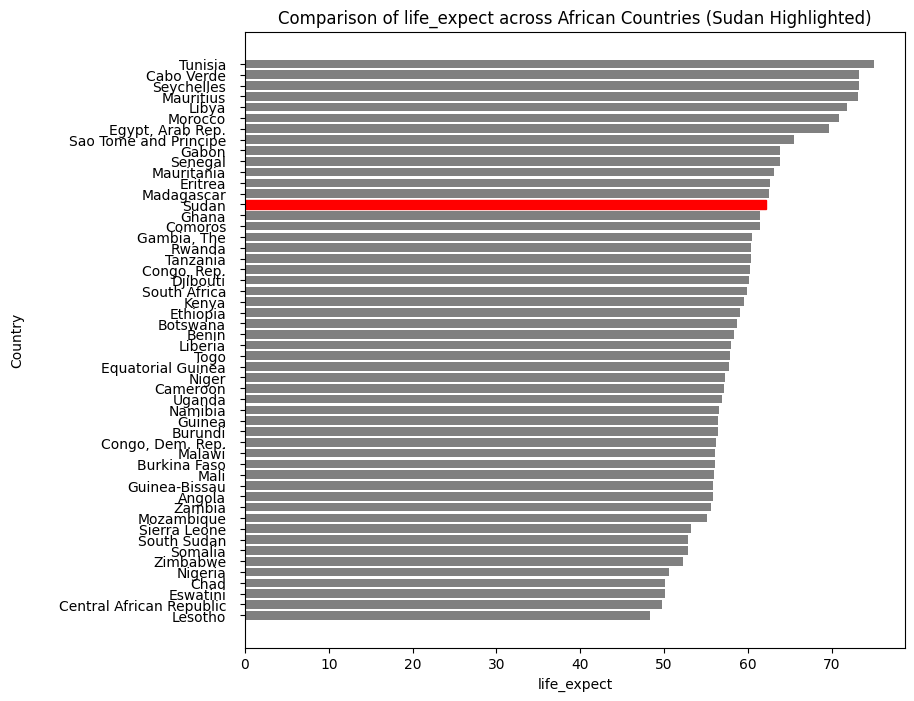

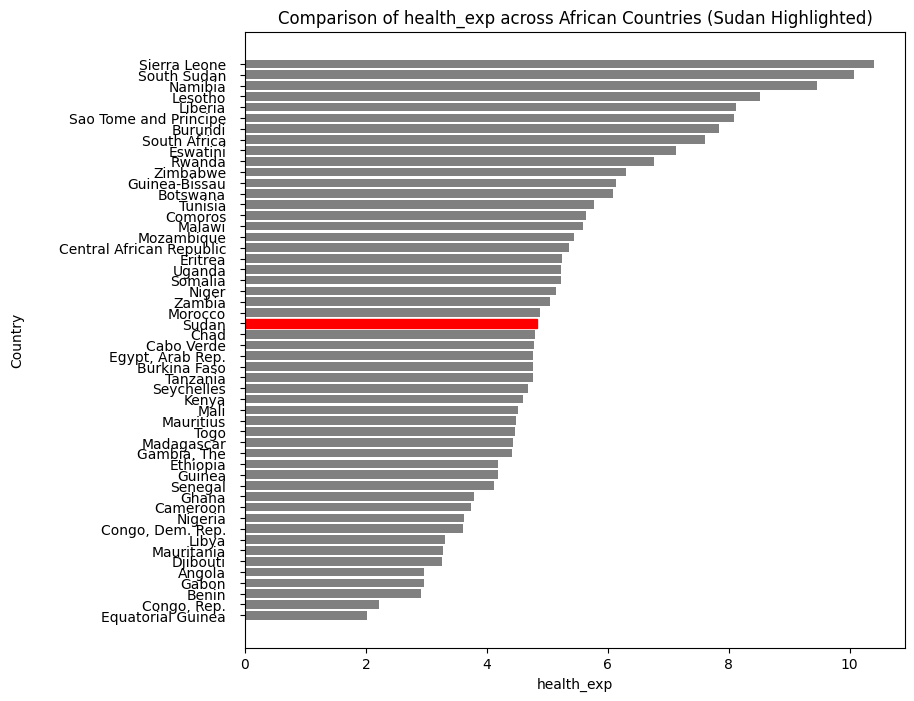

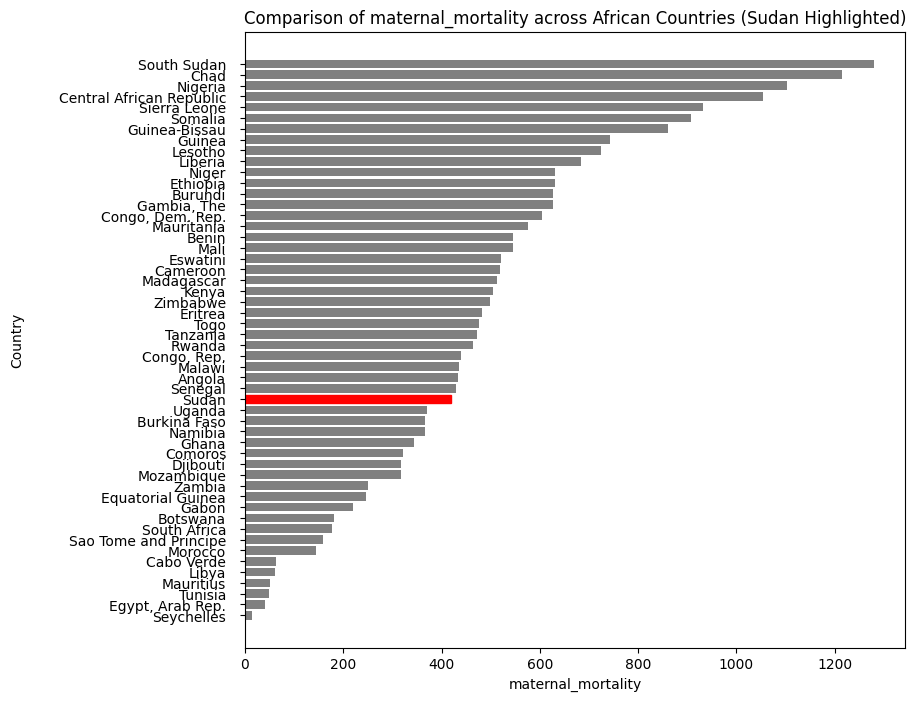

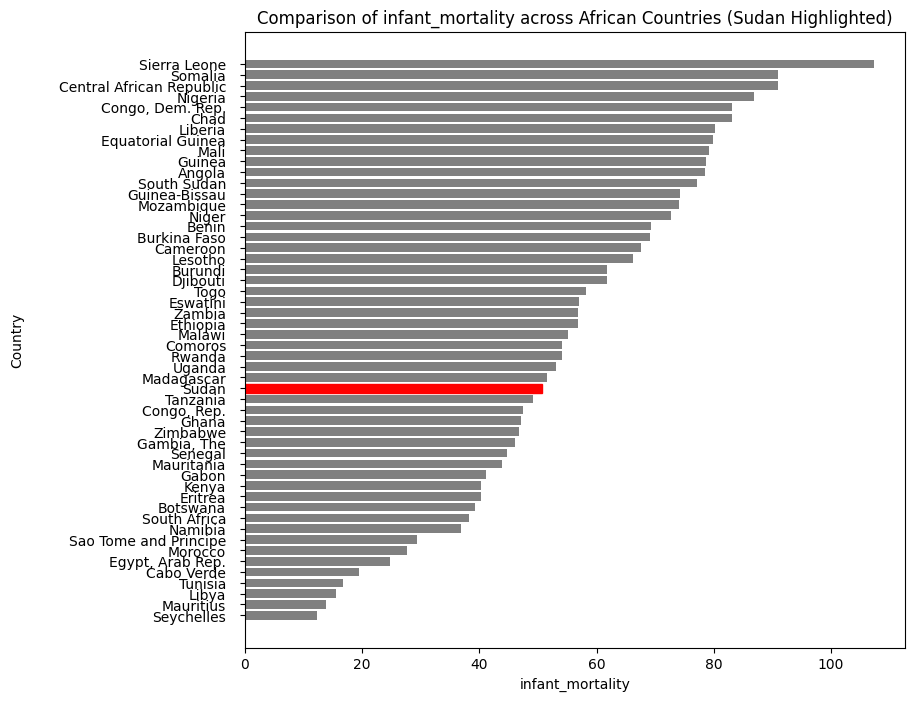

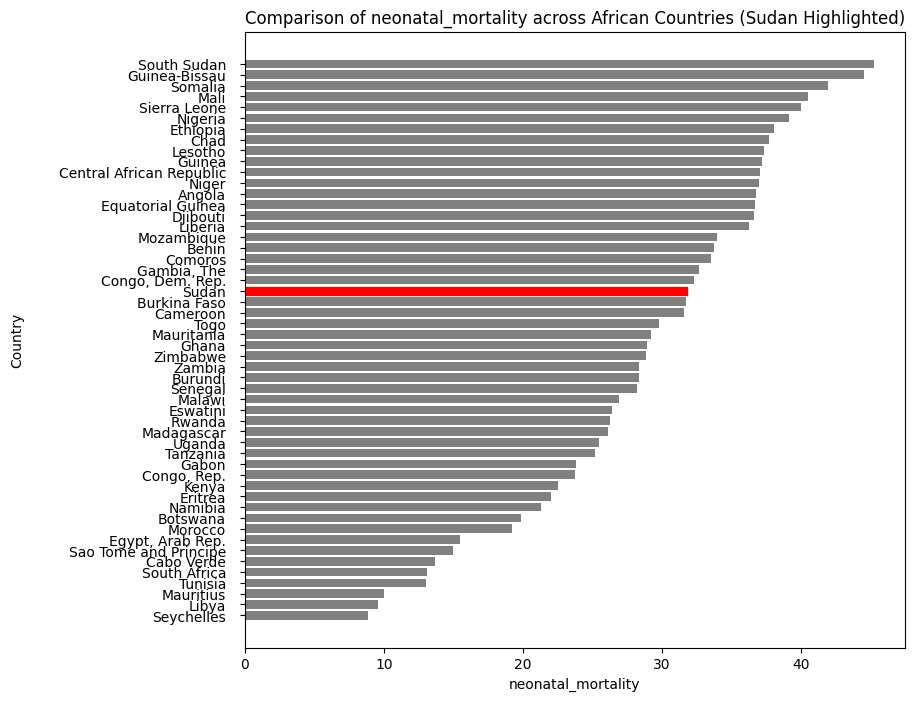

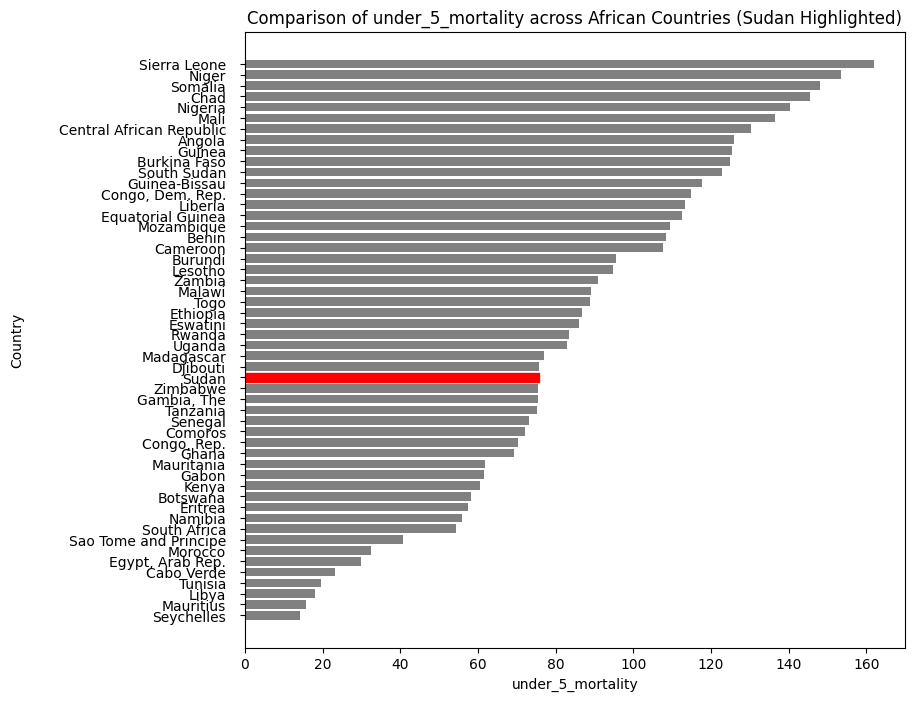

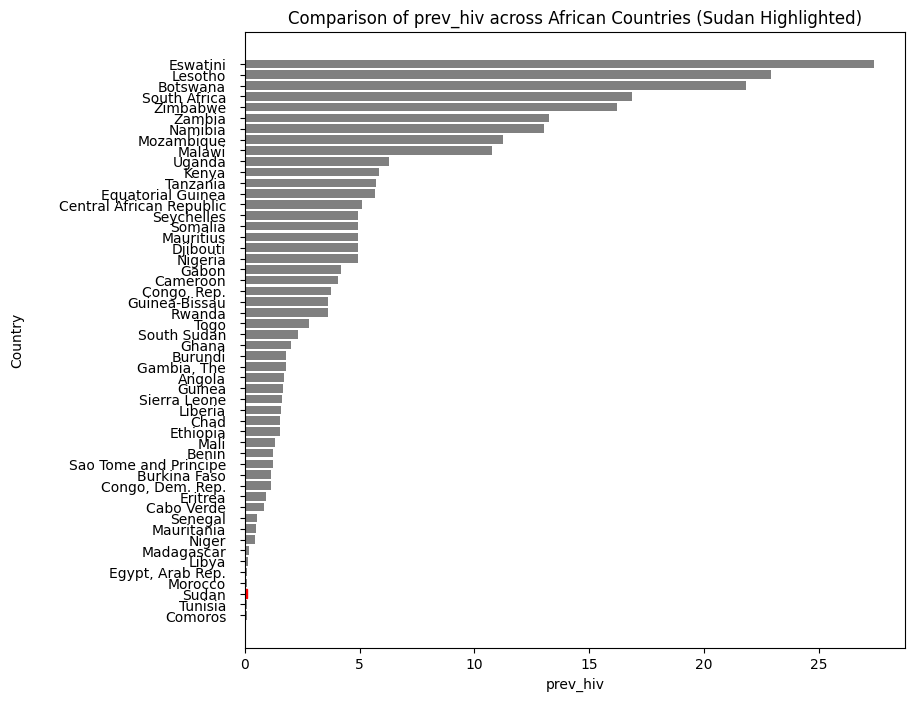

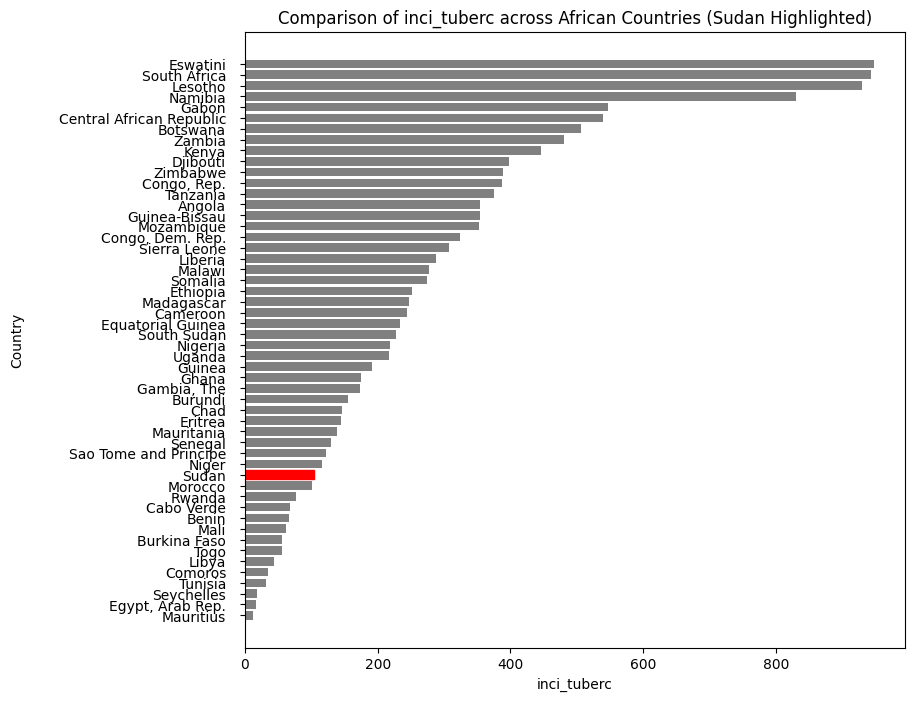

In [12]:
# Compare Sudan to others on key health indicators
#plt.subplots_adjust(hspace=0.5)
plot_sudan_vs_others(african_data, 'life_expect')
plot_sudan_vs_others(african_data, 'health_exp')
plot_sudan_vs_others(african_data, 'maternal_mortality')
plot_sudan_vs_others(african_data, 'infant_mortality')
plot_sudan_vs_others(african_data, 'neonatal_mortality')
plot_sudan_vs_others(african_data, 'under_5_mortality')
plot_sudan_vs_others(african_data, 'prev_hiv')
plot_sudan_vs_others(african_data, 'inci_tuberc')

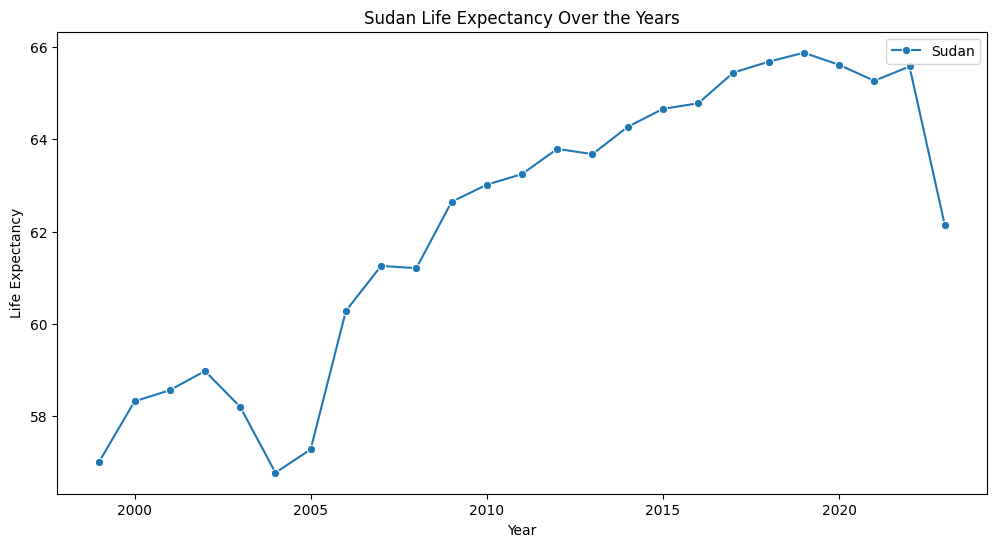

In [13]:
# Sudan's trends over the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=sudan_data, x='year', y='life_expect', marker='o', label='Sudan')
plt.title('Sudan Life Expectancy Over the Years')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.show()

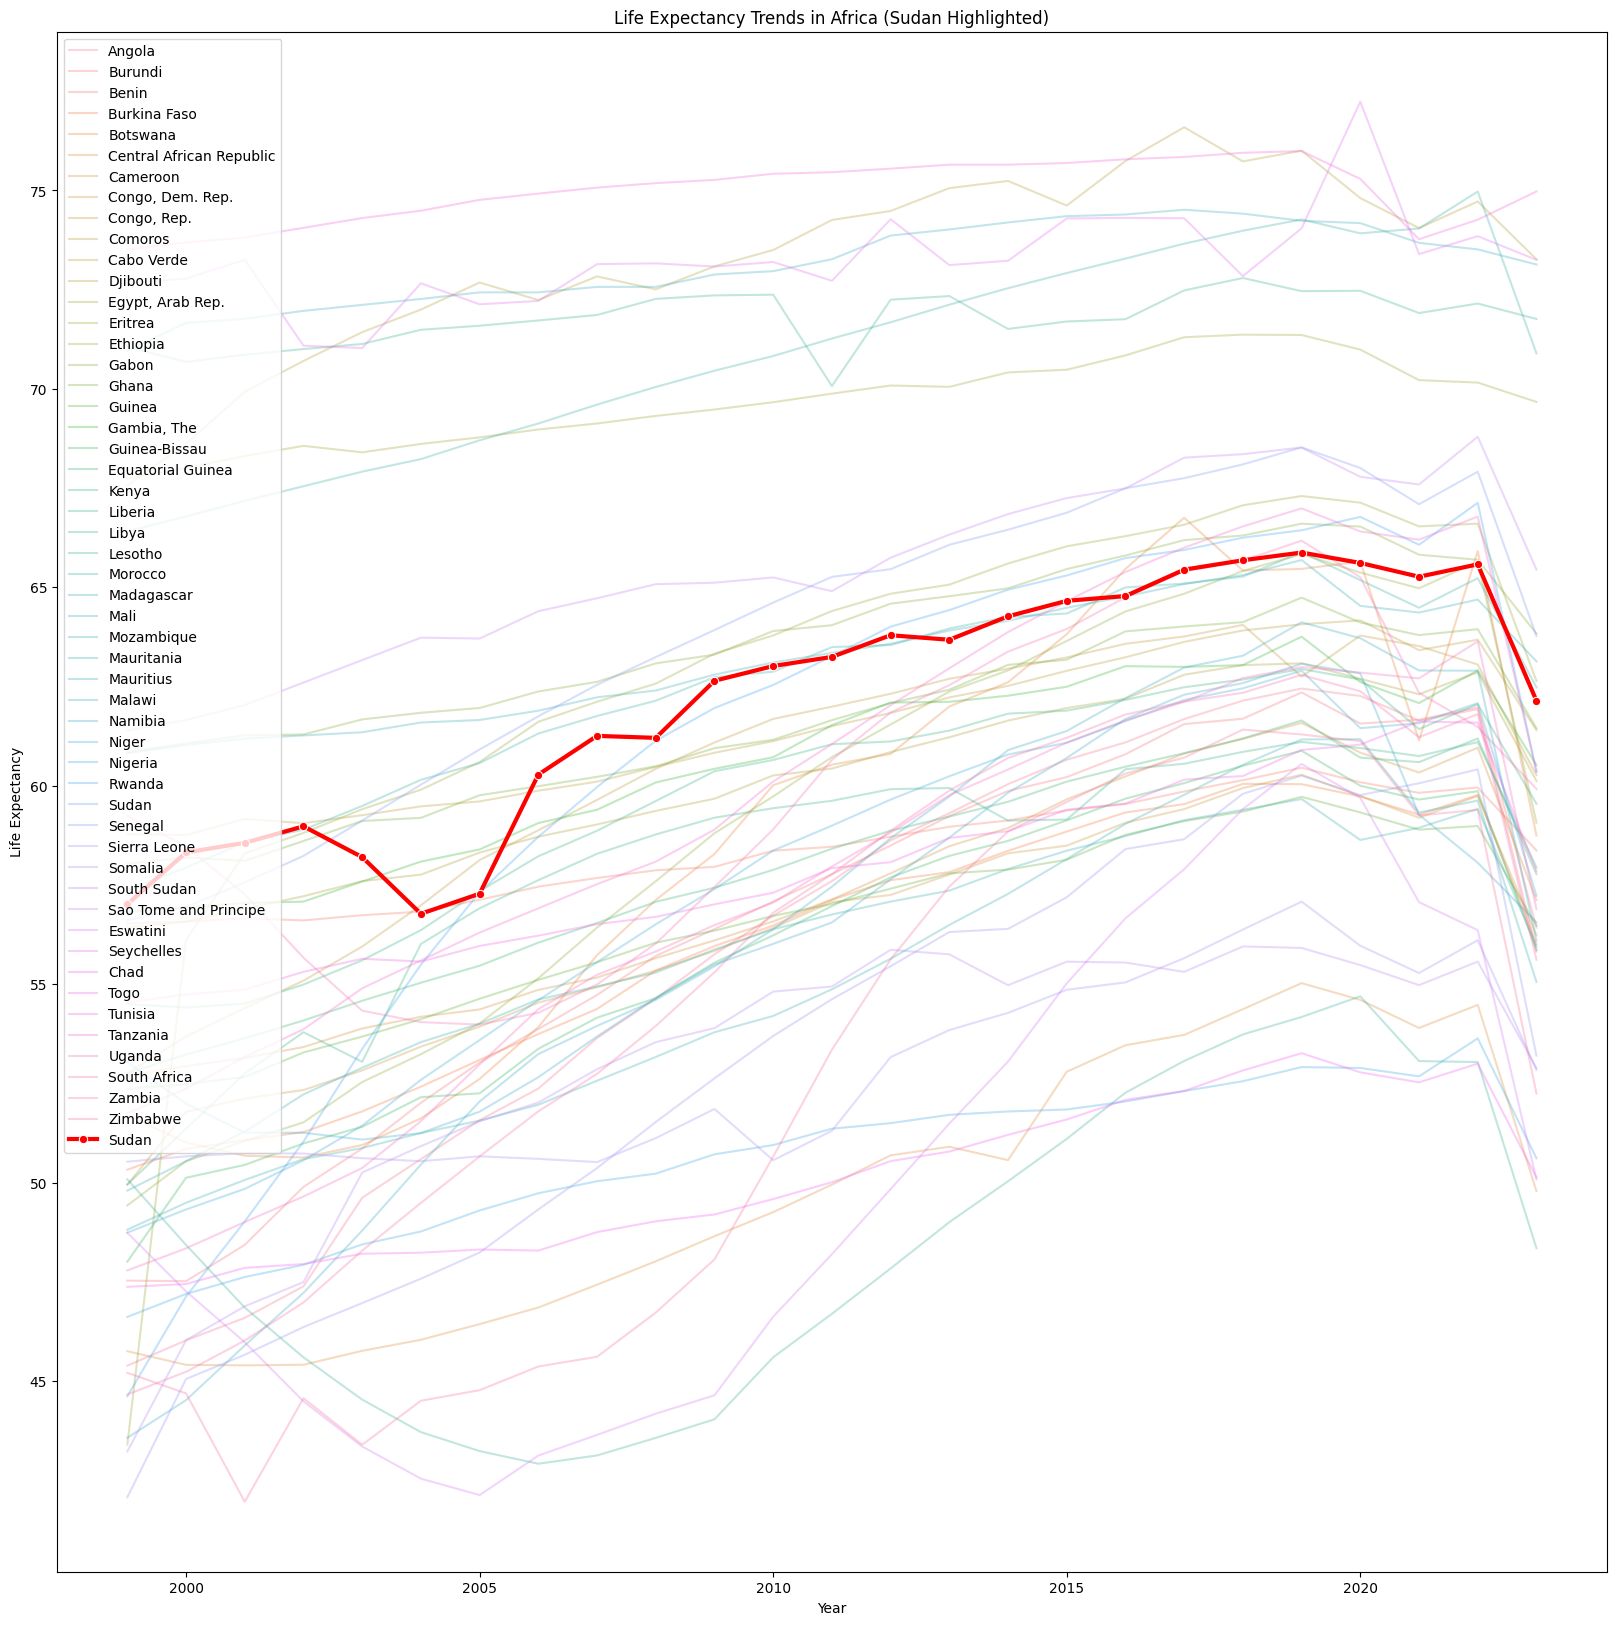

In [14]:
# Sudan vs. Africa (Life Expectancy Trends)
plt.figure(figsize=(20, 20))
sns.lineplot(data=african_data, x='year', y='life_expect', hue='country', alpha=0.3)
sns.lineplot(data=sudan_data, x='year', y='life_expect', marker='o', color='red', linewidth=3, label='Sudan')
plt.title('Life Expectancy Trends in Africa (Sudan Highlighted)')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.legend()
plt.show()

In [15]:
# Define target and features for predictive model
target = "life_expect"
features = ['country', 'health_exp', 'maternal_mortality', 'infant_mortality', 'neonatal_mortality',
            'under_5_mortality', 'prev_hiv', 'inci_tuberc']

y = african_data[target]
X = african_data[features]

In [16]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Preprocessing for the 'country' column
preprocessor = ColumnTransformer(
    transformers=[('country', OneHotEncoder(handle_unknown='ignore'), ['country'])],
    remainder='passthrough'
)

In [18]:
# Create model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [19]:
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [20]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.068399293991347


In [21]:
# Feature importance analysis
regressor = model.named_steps['regressor']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = regressor.feature_importances_

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                                      Feature  Importance
56               remainder__under_5_mortality    0.788142
57                        remainder__prev_hiv    0.097449
54                remainder__infant_mortality    0.044387
53              remainder__maternal_mortality    0.026166
58                     remainder__inci_tuberc    0.019953
52                      remainder__health_exp    0.007841
55              remainder__neonatal_mortality    0.003992
15                   country__country_Eritrea    0.002795
38     country__country_Sao Tome and Principe    0.002269
13          country__country_Egypt, Arab Rep.    0.000920
35                     country__country_Niger    0.000595
4                    country__country_Burundi    0.000499
43              country__country_South Africa    0.000411
50                    country__country_Zambia    0.000290
39                   country__country_Senegal    0.000285
49                    country__country_Uganda    0.000217
34            

In [22]:
# Grid Search for model optimization
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best MSE: {-grid_search.best_score_}")

Best Parameters: {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best MSE: 1.635751032404044


In [23]:
# Cross-validation for robustness
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Mean MSE: {-np.mean(scores)}")

Mean MSE: 2.5714206094926295


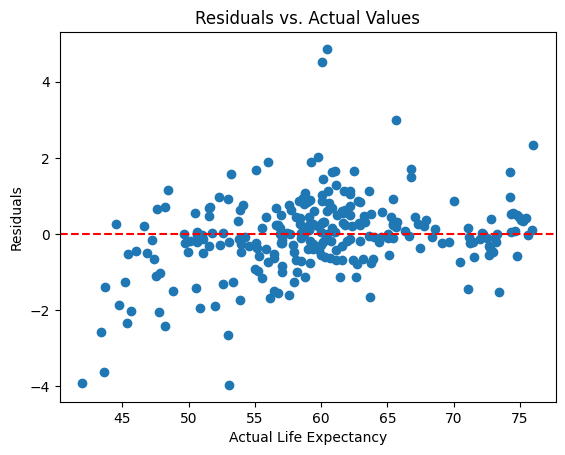

In [24]:
# Residual plot
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Values')
plt.show()

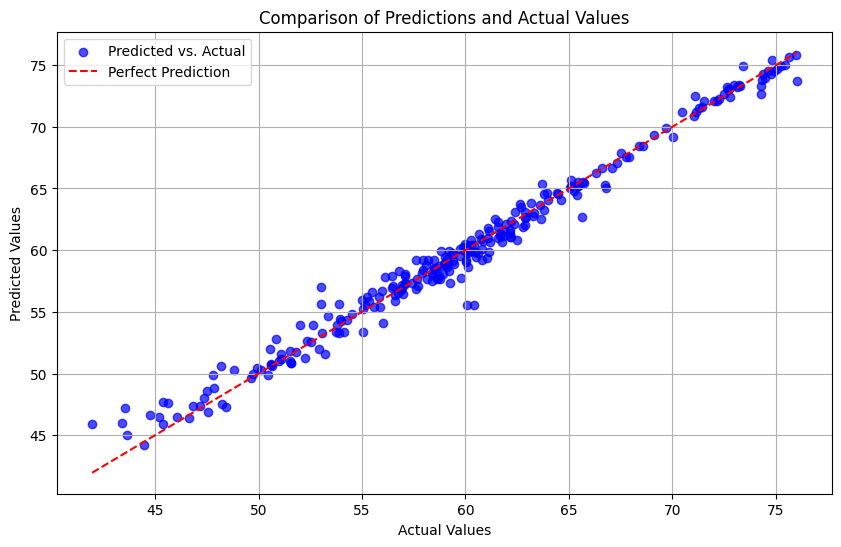

In [25]:
# Predicted vs. Actual Comparison
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predicted vs. Actual', color='blue')
min_val, max_val = min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of Predictions and Actual Values')
plt.legend()
plt.grid(True)
plt.show()

MODELING

In [26]:
# Drop irrelevant columns (modify based on dataset)
df = df.drop(columns=['Country', 'Year'], errors='ignore')  # Keep relevant numerical features

In [28]:
# Handle missing values
# Create a copy of the DataFrame to avoid modifying the original DataFrame
df_numeric = df.select_dtypes(include=np.number).copy()

# Replace missing values with mean for numeric features only
imputer = SimpleImputer(strategy="mean")  # Replace missing values with mean
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

# If you need to keep the non-numeric columns, you can merge the imputed data back with the original DataFrame:
df_final = pd.concat([df.select_dtypes(exclude=np.number), df_imputed], axis=1)

In [29]:
# Define target variable (life expectancy) and features
X = df_imputed.drop(columns=['life_expect'], errors='ignore')  # Features
y = df_imputed['life_expect']  # Target variable

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# Save the scaler for future use
joblib.dump(scaler, "/content/scaler.pkl")

['/content/scaler.pkl']

In [33]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [34]:
# Train, evaluate, and save models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    accuracy = r2 * 100  # Converting R² score to percentage

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2, "Accuracy (%)": accuracy}

    # Save the trained model
    joblib.dump(model, f"/content/{name.replace(' ', '_').lower()}.pkl")

    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}, Accuracy: {accuracy:.2f}%")

Linear Regression - MAE: 2.52, RMSE: 3.54, R²: 0.82, Accuracy: 82.08%
Random Forest - MAE: 0.98, RMSE: 1.73, R²: 0.96, Accuracy: 95.69%
Gradient Boosting - MAE: 1.68, RMSE: 2.28, R²: 0.93, Accuracy: 92.55%
XGBoost - MAE: 1.18, RMSE: 1.80, R²: 0.95, Accuracy: 95.38%


In [35]:
# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:\n", results_df)


Model Performance Comparison:
                         MAE      RMSE        R²  Accuracy (%)
Linear Regression  2.516931  3.537579  0.820802     82.080204
Random Forest      0.977324  1.734998  0.956896     95.689586
Gradient Boosting  1.684885  2.281426  0.925470     92.546960
XGBoost            1.181223  1.795818  0.953821     95.382087


In [36]:
# Save results to a CSV file
results_df.to_csv("/content/model_performance.csv")

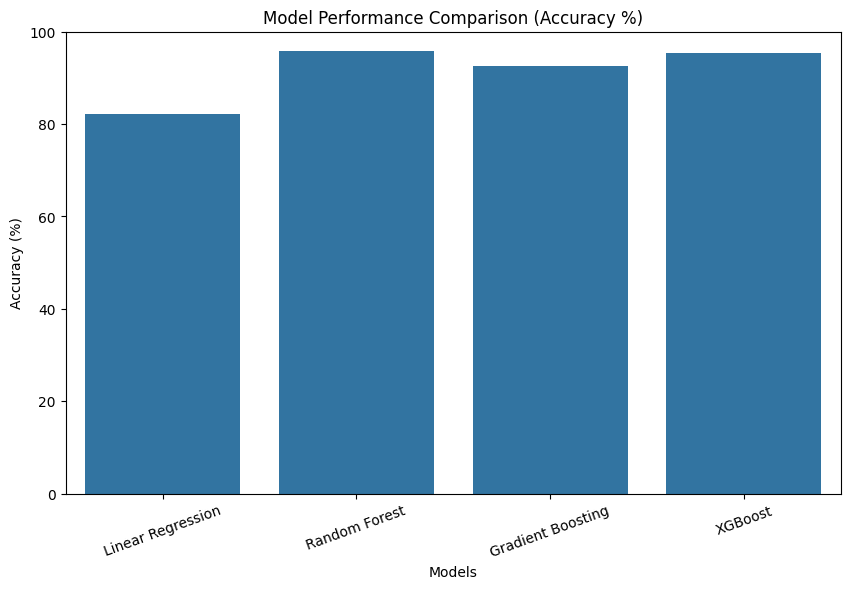

In [37]:
# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df["Accuracy (%)"])
plt.title("Model Performance Comparison (Accuracy %)")
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.xticks(rotation=20)
plt.show()